# Introduction to Feature Improvement & Data Cleaning

------------------------------------------------------
## Applications of Machine Learning

**Vanessa Gómez Verdejo** vanessag@ing.uc3m.es


In this session, we are going to take the results of our understanding of the data and use them to improve the data. **Feature improvement** is about recognizing areas of issue and improvement in our data and figuring out which cleaning methods will be the most effective. Once we detect problems in our data, instead of immediately dropping rows/columns, we should think about the best ways of fixing these problems. More often than not, our machine learning performance will thank us in the end.

In this notebook we will explore different techniques for preparing/improving our datasets before using them with a ML pipeline. In particular, we will review:
* the usefulness of the **data normalization** and other **data transformations**,
* how to deal with **missing values**,
* and how to clean our data from **outliers**. 

In [1]:
from IPython.core.display import Image, display
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import pandas as pd


# Configuración de las figuras matplotlib
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams.update({'font.size': 8})

# 1. Data normalization

To analyze the need of the data normalization, let's work with the boston dataset.

In [3]:
from sklearn.datasets import load_boston

boston = load_boston()
data = boston['data']
targets = boston['target']

In [4]:
columnas = [cc for cc in boston['feature_names']] +['target']
boston_df = pd.DataFrame(np.vstack((data.T, targets)).T, columns=columnas)
boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


As we can see by looking at the mean values and standard deviations of each variable, the variables in this problem have very different ranges. Methods based on distances between observations, such as k-NN or kernel methods, are very dependent on the dynamic ranges of the variables. 

To analyze this, let's solve a mini-problem with only 100 observations and the AGE and RM variables using k-NN.

In [5]:
boston_df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'target'],
      dtype='object')

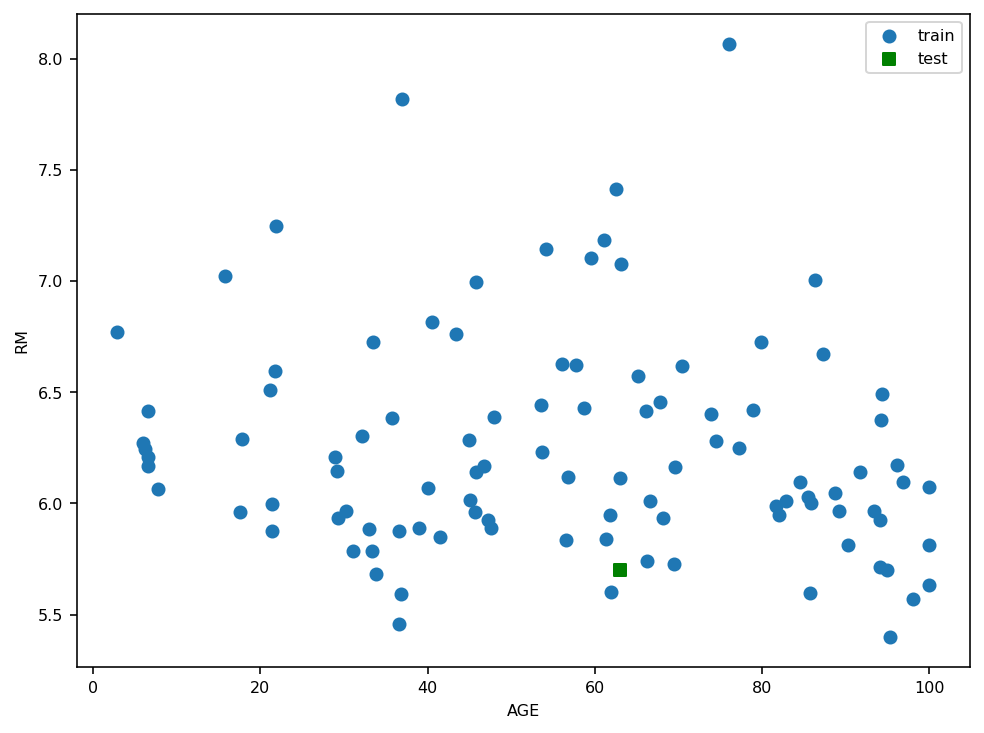

In [6]:
mini_boston = boston_df.loc[:100,['AGE','RM','target']]
xt = np.array([63,5.7])
plt.figure()
plt.scatter(mini_boston['AGE'].values,
            mini_boston['RM'].values, label='train')
plt.scatter(xt[0],xt[1],marker='s',color='green', label='test')
plt.legend()
plt.xlabel('AGE')
_=plt.ylabel('RM')

Which data are the 5 closest neighbors to the test observation?

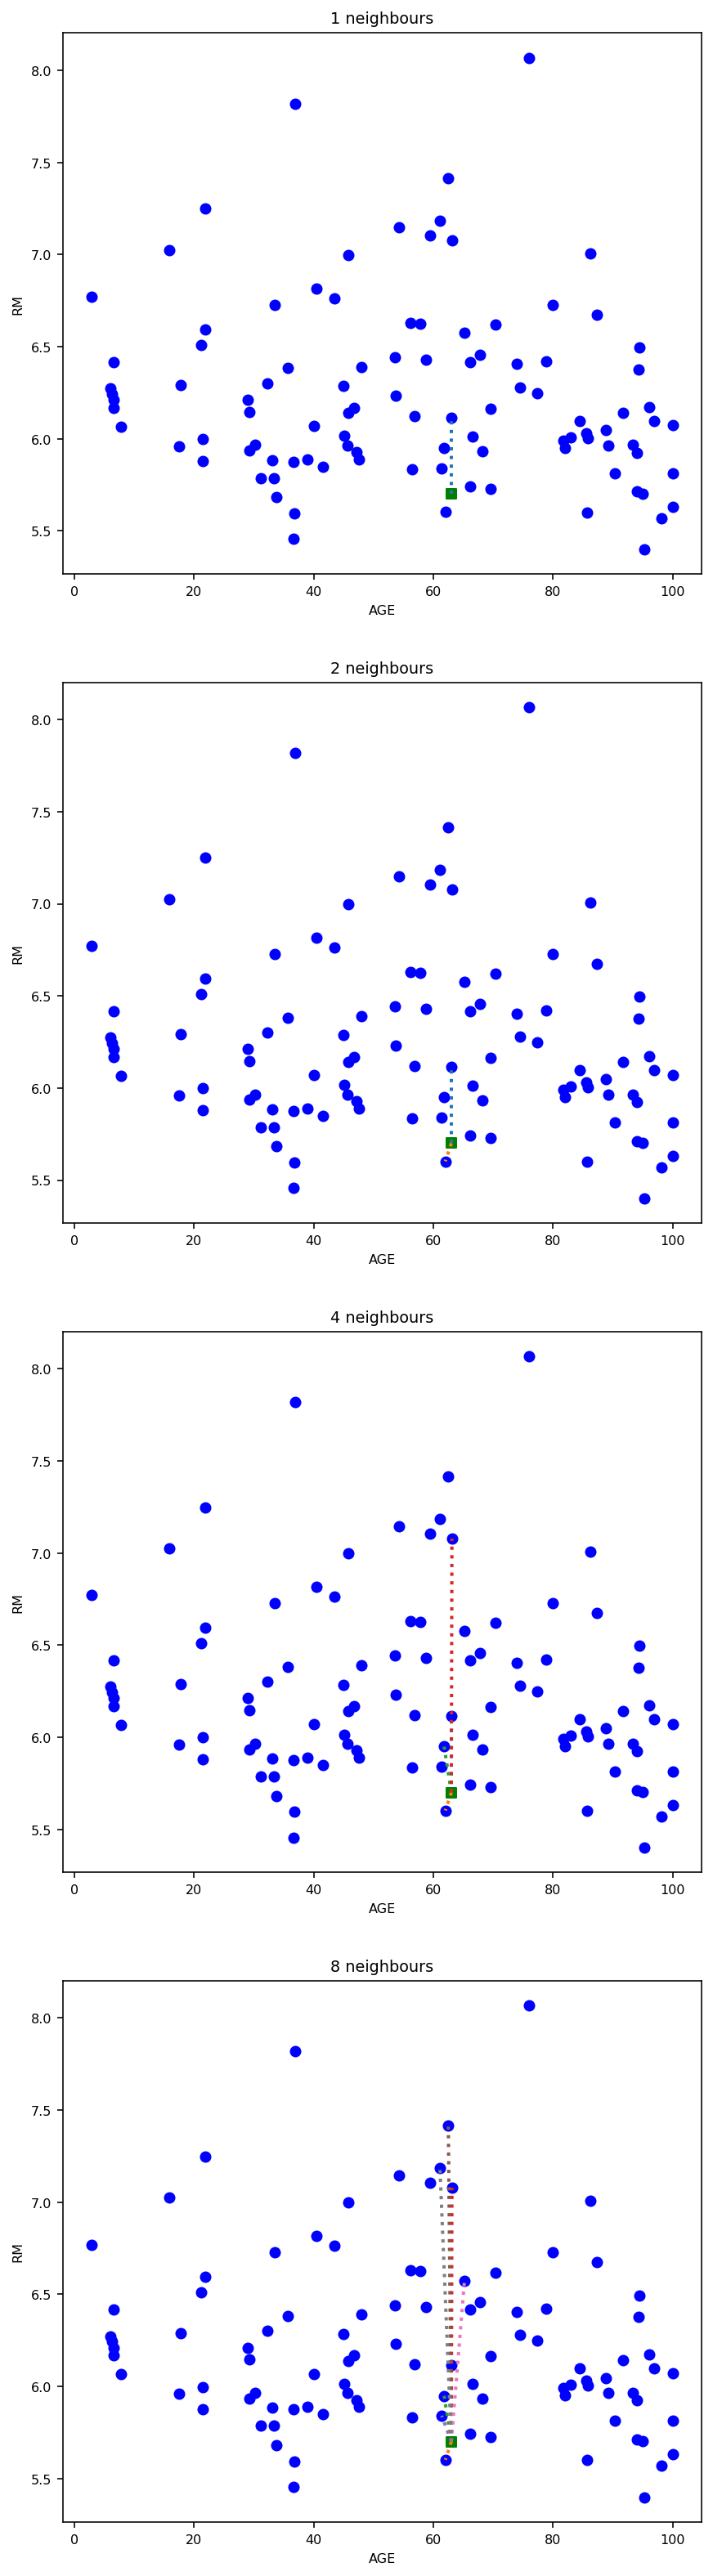

In [7]:
from sklearn.metrics import pairwise_distances 
def plot_example(x,y,xt,ax):
  ax.scatter(x[:,0],x[:,1],color='blue',marker='o')
  ax.scatter(xt[0], xt[1], marker='s', color='green')

def plot_radio(c,x,ax):
  for ii in range(len(x)):
    ax.plot([c[0],x[ii,0]],
            [c[1],x[ii,1]],
            linestyle=':',
            linewidth=2)

x = mini_boston.loc[:,['AGE','RM']].values
y = mini_boston['target'].values

distances = pairwise_distances(xt.reshape(1,-1), x,'euclidean') 

# Sort all neighbours for the test data
id_neigh = np.argsort(distances) # indexes over the training data, which one is the k-th neighbour?

sorted_distances = 1e-6+np.sort(distances) # distances to neighbours how far away is the k-th neighbour?

# class each neighbour votes for
call_neigh = y[id_neigh]

v_k = np.array([1,2,4,8])
ii=7
fx,ax = plt.subplots(len(v_k),1,figsize=(ii,len(v_k)*ii))
for ik,kk in enumerate(v_k):
  plot_example(x,y,xt,ax[ik]) 
  plot_radio(xt,np.array([x[cc,:] for cc in id_neigh[0,:kk]]),ax[ik])
  ax[ik].set_title('{0:d} neighbours'.format(kk))
  ax[ik].set_xlabel('AGE')
  _=ax[ik].set_ylabel('RM')

Neighbors are found by using only RM! Why do you think that this is happening?

We need to normalize the data so that AGE is also taken into account. 

### Data normalization

The usual preprocessing in machine learning is **standardize** each variable, that is, transform each column so that it has a mean of 0 and variance of 1.

In sklearn this is achieved with the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).


In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x) 
print("Means of the variables without scaling")
print(x.mean(0))
print("Standard deviations of the variables without scaling")
print(x.std(0))
x_s = scaler.transform(x)
print("Means of the scaled variables")
print(x_s.mean(0))
print("Standard deviations of the scaled variables")
print(x_s.std(0))
xt_s = scaler.transform(xt.reshape(-1,2))[0]
print("Test sample")
print(xt_s)

Means of the variables without scaling
[56.48613861  6.23928713]
Standard deviations of the variables without scaling
[27.30395478  0.4883953 ]
Means of the scaled variables
[-7.41980734e-16 -4.16608442e-16]
Standard deviations of the scaled variables
[1. 1.]
Test sample
[ 0.23856842 -1.10420213]


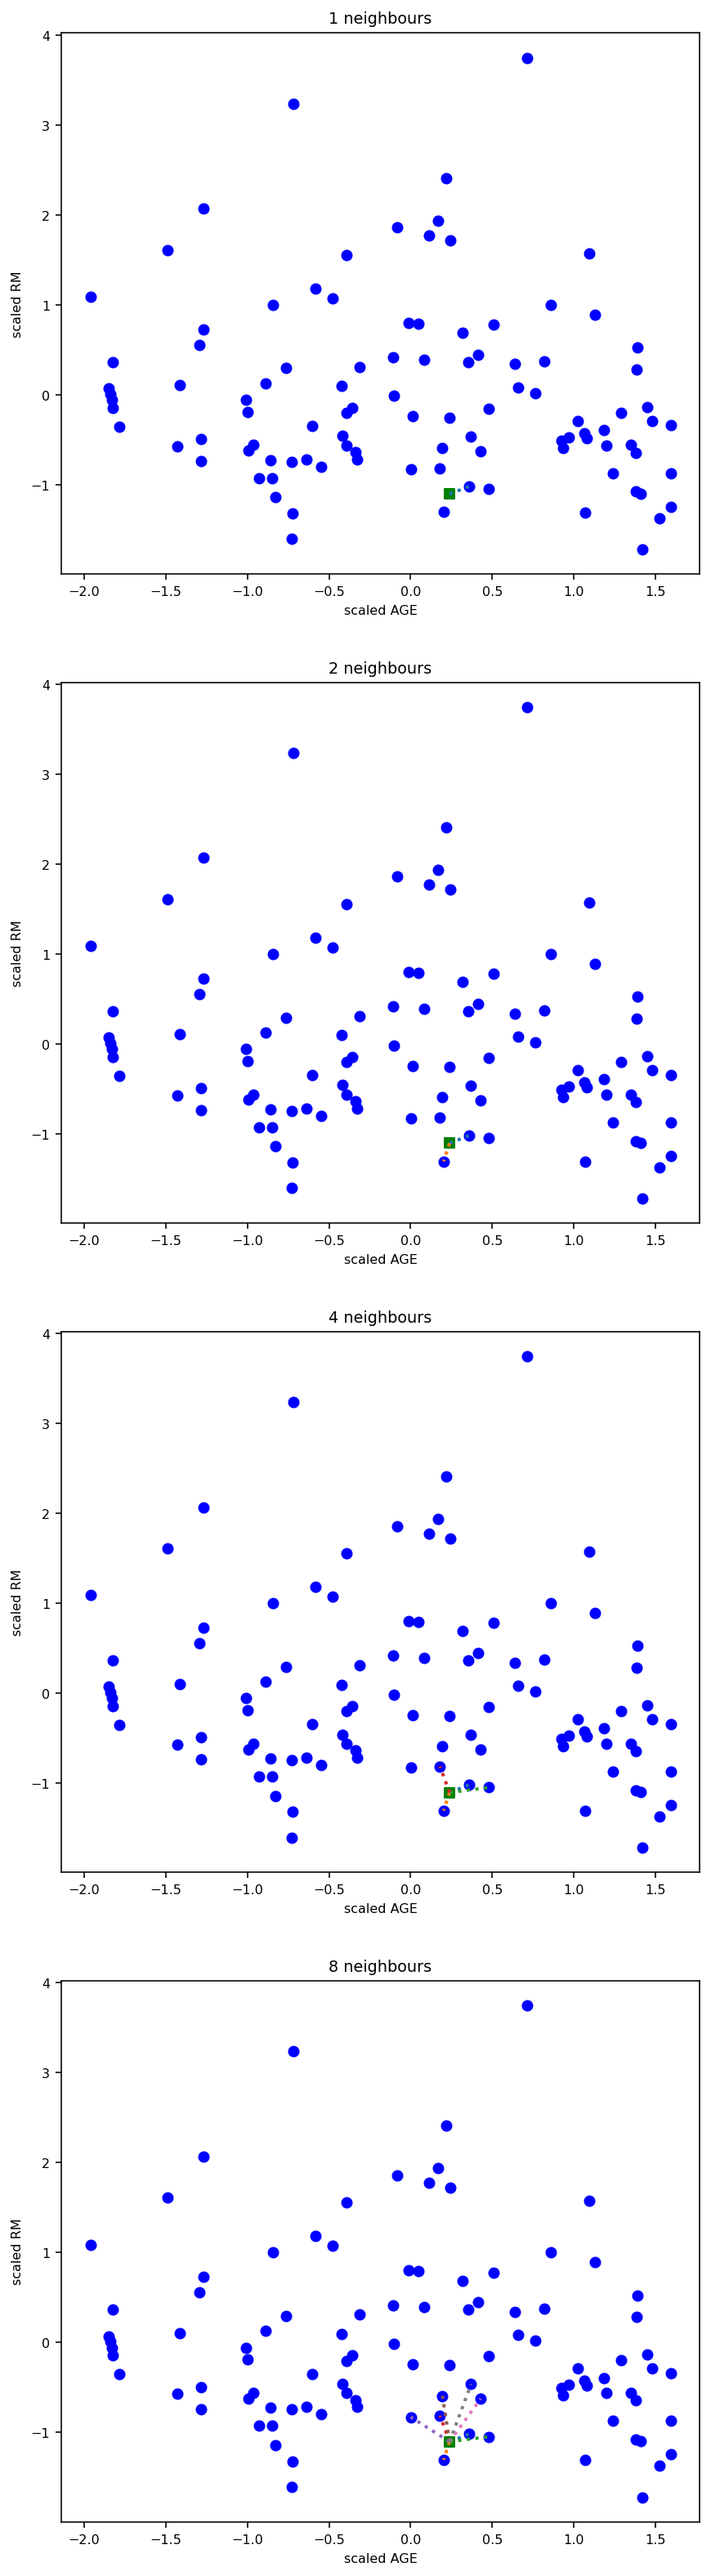

In [9]:
distances = pairwise_distances(xt_s.reshape(1,-1), x_s,'euclidean') 

# Sort all neighbours for the test data
id_neigh = np.argsort(distances) # indexes over the training data, which one is the k-th neighbour?

sorted_distances = 1e-6+np.sort(distances) # distances to neighbours how far away is the k-th neighbour?

v_k = np.array([1,2,4,8])
ii=7
fx,ax = plt.subplots(len(v_k),1,figsize=(ii,len(v_k)*ii))
for ik,kk in enumerate(v_k):
  plot_example(x_s,y,xt_s,ax[ik]) 
  plot_radio(xt_s,np.array([x_s[cc,:] for cc in id_neigh[0,:kk]]),ax[ik])
  ax[ik].set_title('{0:d} neighbours'.format(kk))
  ax[ik].set_xlabel('scaled AGE')
  _=ax[ik].set_ylabel('scaled RM')

### Influence of the scaling in the ML model result

Now, let's combine scaling and cross-validation to check if the results of k-NN improve using normalized data and the neighbors are calculated with equal impact of the dimensions.

We have to be careful when combining preprocessing with model learning because preprocessing **can only be learned with training samples**, if we use test samples to learn preprocessing, we would be cheating.



**1. Results without scaling the variables**

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size=0.3, random_state=42)

In [11]:
from sklearn.neighbors import KNeighborsRegressor
kNN = KNeighborsRegressor(n_neighbors=5)
kNN.fit(x_train, y_train)
R2_train = kNN.score(x_train, y_train)
R2_test = kNN.score(x_test, y_test)
print("Without scaling")
print("R^2 over training data: {0:.2f}".format(R2_train))
print("R^2 over test data: {0:.2f}".format(R2_test))

Without scaling
R^2 over training data: 0.66
R^2 over test data: 0.58


**2. Results scaling the variables**

In [12]:
# Data normalization
scaler = StandardScaler()
scaler.fit(x_train, y_train)
xrs = scaler.transform(x_train)
xts = scaler.transform(x_test)

# Model training
kNNs = KNeighborsRegressor(n_neighbors=5)
kNNs.fit(xrs, y_train)
R2_trains = kNNs.score(xrs, y_train)
R2_tests = kNNs.score(xts, y_test)

print("With scaling")
print("R^2 over training data: {0:.2f}".format(R2_trains))
print("R^2 over test data: {0:.2f}".format(R2_tests))

With scaling
R^2 over training data: 0.85
R^2 over test data: 0.75


As expected, the performance of the k-NN algorithm has improved. This behavior is expected in any ML model based on distance calculation. How do you think this can affect linear models such as linear regression model or logistic regression, or other models such as decision trees?

Although the use of `StandardScaler()` is the most common option for standardizing data, there are other options for this rescaling:
* [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html): transforms features by scaling each feature to a given range.
* [`RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html): If your data contains many outliers, scaling using the mean and variance of the data is likely to not work very well. In these cases, `RobustScaler` will center the data to the median and component wise scale according to the interquartile range.
* [`MaxAbsScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html): It scales each feature by its maximum absolute value. It is a good choice for sparse data to avoid losing the data sparsity.

# Other data transformations

## Discretization of continuous variables
Another transformation that may be of interest when working with continuous variables is to change their distribution to a uniform or Gaussian.

The transformation to **uniform** tends to separate the most frequent values of that variable and concentrate the less frequent ones, thus contributing to reduce the impact of *outliers*. As it is a **non-linear** transformation, linear correlations between variables can be distorted.

The transformation to **Gaussian** tends to concentrate values around their average. This is very useful (sometimes mandatory) when the subsequent learning model is designed to work with gaussian data distributions (linear regression models, principal component analysis, euclidean distance based models/kernels, ...).

There are several options to get this transformation:
* When the data values expand by several orders of magnitude, but most of the values are around the first order, we can just apply a logarithmic transformation of the data (for example, see the behavior of variable CRIM).
* In case we are working with pandas dataframes, we can use the [`quantile`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.quantile.html) function in combination with the numpy function [`digitize`](https://numpy.org/doc/stable/reference/generated/numpy.digitize.html) to get a uniform distribution.

* Or, in a more general way, we can use the function [`sklearn.preprocessing.quantile_transform`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.quantile_transform.html#sklearn.preprocessing.quantile_transform). This function uses an estimate of the cumulative distribution function of each feature to map the original values to the desired output distribution (uniform or gaussian).


Let's see how this last transformation and how it affects the results in the Boston problem.

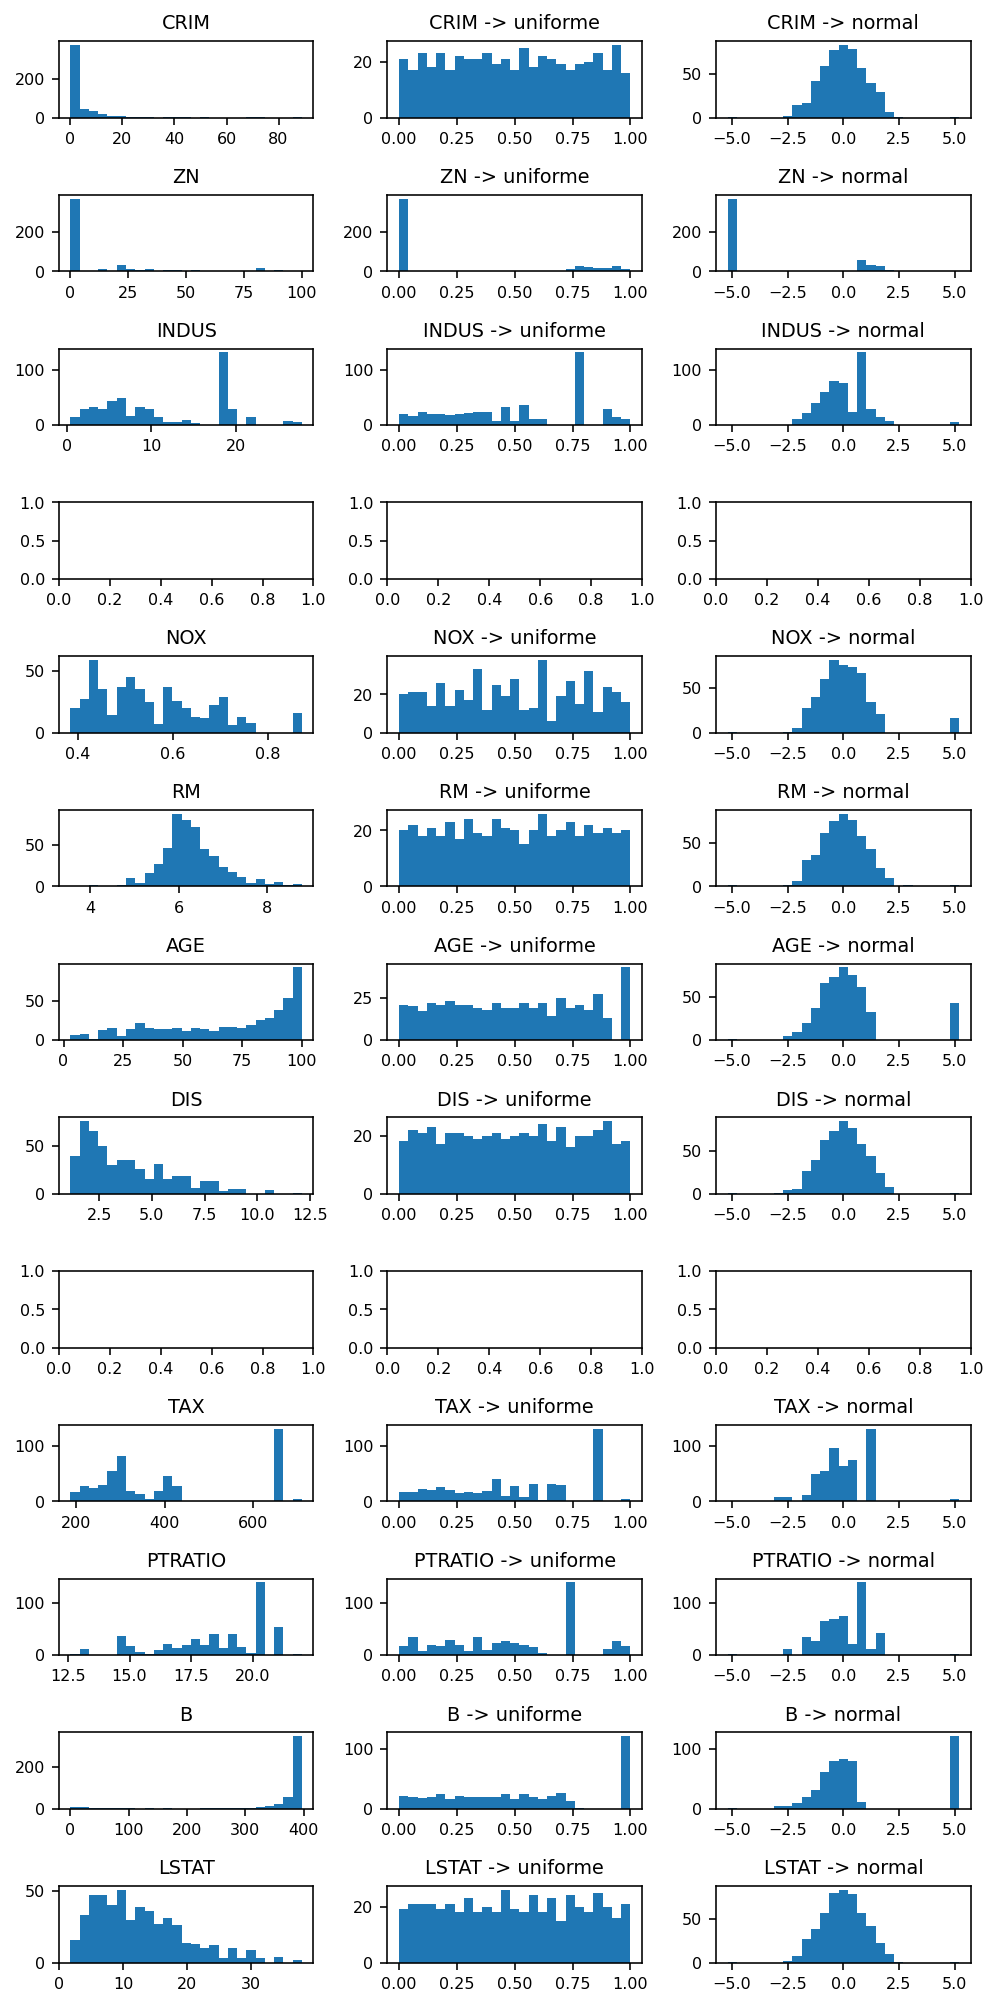

In [13]:
from sklearn.preprocessing import quantile_transform
ndim = data.shape[1]
fx, ax = plt.subplots(ndim, 3, figsize=(7,14))
nbins = 25
for jj in range(ndim):
  xjj = data[:,jj]
  if len(np.unique(xjj)) < nbins:
    continue
  ax[jj][0].hist(xjj,nbins)
  ax[jj][0].set_title('{0}'.format(boston_df.columns[jj]))
  xjj_u = quantile_transform(xjj.reshape(-1,1), n_quantiles=nbins, random_state=42, copy=True)
  ax[jj][1].hist(xjj_u, nbins)
  ax[jj][1].set_title('{0} -> uniforme'.format(boston_df.columns[jj]))
  xjj_n = quantile_transform(xjj.reshape(-1,1), n_quantiles=nbins, random_state=42, copy=True, output_distribution='normal')
  ax[jj][2].hist(xjj_n, nbins)
  ax[jj][2].set_title('{0} -> normal'.format(boston_df.columns[jj]))
fx.tight_layout()

We can explore with `GridSearchCV` the impact of these transformations on the final result.

In [14]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
v_nbins = [5,10,20,25,100,200,x_train.shape[1]]
param_grid = {
    'quantile__n_quantiles':v_nbins,
    'quantile__output_distribution':['uniform','normal'],
    'kNN__n_neighbors': [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100],
    'kNN__weights':['uniform','distance'],
}
pipe = Pipeline([('scaler', StandardScaler()),('quantile', QuantileTransformer()), ('kNN', KNeighborsRegressor())])
grid_knn = GridSearchCV(pipe, param_grid, cv=5)
grid_knn.fit(x_train, y_train)
R2_train = grid_knn.score(x_train, y_train)
R2_test = grid_knn.score(x_test, y_test)
print("R^2 en el conjunto de entrenamiento: {0:.2f}".format(R2_train))
print("R^2 en el conjunto de test: {0:.2f}".format(R2_test))
print(grid_knn.best_params_)

R^2 en el conjunto de entrenamiento: 1.00
R^2 en el conjunto de test: 0.67
{'kNN__n_neighbors': 5, 'kNN__weights': 'distance', 'quantile__n_quantiles': 25, 'quantile__output_distribution': 'uniform'}


## One-Hot Encoding Transformation

The [**One-Hot encoding**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) transformation aims to be able to use categorical variables within a model designed for continuous variables. 

Let's consider a categorical variable with $M$ possible values, for example the variable `group` that can take 3 values `A`, `B` or `C`. One-hot encoding transforms each categorical variable into $M$ binary variables (they only take the value 1 or 0) which are arranged like this:
If an observation has the value $m$ in the categorical variable, all binary variables take the value 0, except the $m$-th, which takes the value 1.

In the example, the variable `group` would be transformed into 3 variables, [`group_A`, `group_B` and `group_C`] which would code the observations as follows:
- `group`=`A` $\rightarrow$ [`group_A`=`1`, `group_B`=`0`, `group_C`=`0`]
- `group`=`B` $\rightarrow$ [`group_A`=`0`, `group_B`=`1`, `group_C`=`0`]
- `group`=`C` $\rightarrow$ [`group_A`=`0`, `group_B`=`0`, `group_C`=`1`]

In the Boston Housing database, the variable `CHAS`, which measures whether the property faces the Charles River, is coded one-hot, but with the option `drop`=`"if_binary"`.

To see how this process works in a real problem, we will work with a database of a credit problem ([german dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc)). Each observation has data of the clients and of the concrete operation. The *target* indicates if the operation went well (*target*=1) or not (*target*=2). When loading the data we have transformed the *target*=2 into zeros to follow the notation usually used.
Before applying any transformation, we are going to divide the variables (except the *target*) in two lists:
- v_cat', with the names of the variables that are categorical
- v_num', with the names of the variables being numeric

In [15]:
def load_data():
  data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data',
                     delimiter=" ",
                     header=None)
  data.columns=['existingchecking', 
                'duration', 
                'credithistory', 
                'purpose', 
                'creditamount', 
                'savings', 
                'employmentsince', 
                'installmentrate', 
                'statussex', 
                'otherdebtors', 
                'residencesince', 
                'property', 
                'age', 
                'otherinstallmentplans', 
                'housing', 
                'existingcredits', 
                'job', 
                'peopleliable', 
                'telephone', 
                'foreignworker', 
                'target'
                ]
  data.loc[:,'target'] = data['target'].replace([1,2],[1,0])
  return data

In [16]:
data = load_data()
X = data[data.columns[:20]].values
Y = data['target'].values
data.head()

,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


In [17]:
# Divide variables into categorial and continuous
v_cat = [element for element in data.dtypes[(data.dtypes=='O')].index.values if element != 'target']
v_num = [element for element in data.dtypes[(data.dtypes!='O')].index.values if element != 'target']
target = ['target']

print(v_cat)
print(v_num)


['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince', 'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 'telephone', 'foreignworker']
['duration', 'creditamount', 'installmentrate', 'residencesince', 'age', 'existingcredits', 'peopleliable']


We will now use sklearn's *one hot encoder* method to code the categorical variables. In addition, we will use the [`get_feature_names`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder.get_feature_names) method to assign a name to each transformed variable so that it is related to the original variable.

In [18]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
v_cat_transf = onehot.fit_transform(data[v_cat])
# By default v_cat_transf es a sparse CSR matrix, 
# so we convert it to dense matrix to construct our new dataframe
v_cat_transf = v_cat_transf.toarray()

# Get names of transformed variables
columnas_onehot = onehot.get_feature_names(v_cat)
columnas_onehot

# New dataframe with codified categorical variables
one_hot_encoded_frame =  pd.DataFrame(v_cat_transf, columns= columnas_onehot)
one_hot_encoded_frame.head()

,existingchecking_A11,existingchecking_A12,existingchecking_A13,existingchecking_A14,credithistory_A30,credithistory_A31,credithistory_A32,credithistory_A33,credithistory_A34,purpose_A40,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreignworker_A201,foreignworker_A202
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [19]:
# We join categorial ans continious variables
data_ohe = pd.concat([one_hot_encoded_frame,data[v_num],data[target]],axis=1)
data_ohe.head()

,existingchecking_A11,existingchecking_A12,existingchecking_A13,existingchecking_A14,credithistory_A30,credithistory_A31,credithistory_A32,credithistory_A33,credithistory_A34,purpose_A40,...,foreignworker_A201,foreignworker_A202,duration,creditamount,installmentrate,residencesince,age,existingcredits,peopleliable,target
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,6,1169,4,4,67,2,1,1
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,48,5951,2,2,22,1,1,0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,12,2096,2,3,49,1,2,1
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,42,7882,2,4,45,1,2,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,24,4870,3,4,53,2,2,0


One hot encoding is quite intuitive but it has **collinearity problems**. If we use linear methods because the columns it generates are not linearly independent, since the sum of all the elements in each row gives 1. To learn a linear model we can add noise to the observations to eliminate collinearity. 

**Dummy coding** corrects the collinearity defect of *one-hot encoding* by removing one of the features. This feature corresponds to a category called **reference category** which is represented with zeros in all features corresponding to the other categories.

In *scikit learn* we use the same class as for *one-hot encoding* but with the parameter `drop` we choose the reference category.

## Hashing of features

When the number of feature categories is very large the above techniques produce unwieldy results. In this case, we can use a **Hashing of features** where each category is transformed into a code of $m$ components, which in principle can be dense. In the *one-hot encoding* variants the code has a length equal to the number of categories (minus one) and with the *hashing* function we reduce this code length to a value of $m$.

The *hashing* functions are designed to preserve statistics of the original scalar products, so that the *hashed* variables can be used within linear models.

The price paid for this reduction in dimension is that the $m$ categories resulting from *hashing are **not interpretable** within the a priori knowledge defined by the problem variables.

We can employ the [*hashing* functionality](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html?highlight=hashing#sklearn.feature_extraction.text.HashingVectorizer) of *scikit learn* for this purpose.


In [20]:
from sklearn.feature_extraction import FeatureHasher 

h =FeatureHasher(n_features=8, # number of columns of the outut
                input_type='string')
v_cat_transf_hashing = h.transform(data[v_cat]) # notice you don't need fit


print("Show the output of the hash")
v_cat_transf_hashing .toarray()[:20,:]

Show the output of the hash


array([[ 0., -2., -2.,  0., -2., -4.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -3.,  1.,  0.],
       [ 1.,  1.,  0.,  1.,  0.,  0., -2.,  0.],
       [ 0.,  0.,  0., -1., -1., -1.,  0., -2.],
       [ 0., -1.,  0.,  0.,  1., -1.,  0.,  2.],
       [ 1.,  0.,  1., -1.,  0.,  0.,  0., -2.],
       [ 0.,  2.,  0.,  1.,  0., -2.,  0.,  1.],
       [ 0.,  2.,  0.,  0.,  0.,  0., -1.,  1.],
       [ 0.,  1.,  2., -2.,  1., -2., -1.,  0.],
       [ 1.,  0., -1.,  1., -1., -2.,  0., -1.],
       [ 0.,  0.,  0.,  1.,  0., -1.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  0., -1., -1.,  3.],
       [ 0.,  2., -1.,  3., -1., -1.,  0.,  1.]])

# Missing values and data imputation

Part of this section is adapted from this online [tutorial](https://medium.com/@Cambridge_Spark/tutorial-introduction-to-missing-data-imputation-4912b51c34eb)

When we have to face real problems is quite common find that our datasets contain missing values, often encoded as `?`, `nan`, `N/A`, blank cell, or sometimes `-999`, `inf`, `-inf`. The use of these datasets by our scikit-learn estimators is not straightforward since they assume that all values in an array are numerical. 

A basic strategy to use these datasets is to discard entire rows and/or columns containing missing values. However, this comes at the price of losing data which may be valuable (even though incomplete). A better strategy is to impute the missing values, i.e., to infer them from the known part of the data. 

The aim of this section is to provide an introduction of missing data and describe some basic methods on how to handle them. For this purpose, let's use the seaborn dataset `tips` and include at random missing values in some of its variables.



In [21]:
import seaborn as sb
from sklearn.model_selection import train_test_split

tips = sb.load_dataset('tips')

# Use a subset of the data for this example
df = tips.loc[:,['total_bill', 'size', 'tip']]
df = df.sample(frac=1).reset_index(drop=True) # Sort the rows

# Split in train/test partitions
data = df[['total_bill', 'size']]
targets = df['tip']
x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size=0.3, random_state=42)

# Add missing values (NaNs) in variables size and total_bill
df_train_all = pd.DataFrame(np.concatenate((x_train, y_train[:, np.newaxis]), axis=1),columns=['total_bill', 'size', 'tip'])
df_train = df_train_all.copy()
df_train.loc[:20, 'size'] = np.nan
df_train.loc[150:, 'total_bill'] = np.nan
df_train

<ipython-input-21-80b99dc507e9>:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df_train_all = pd.DataFrame(np.concatenate((x_train, y_train[:, np.newaxis]), axis=1),columns=['total_bill', 'size', 'tip'])


,total_bill,size,tip
0,26.88,NaN,3.12
1,27.18,NaN,2.00
2,11.35,NaN,2.50
3,24.71,NaN,5.85
4,13.00,NaN,2.00
...,...,...,...
165,NaN,2.0,2.00
166,NaN,2.0,3.00
167,NaN,4.0,4.34
168,NaN,3.0,3.50


As we can imagine, the simplest thing is to ignore the missing values and consider only the observations in which all the variables are known.

To drop entries with missing values in any column in pandas, we can use:

In [22]:
# Remove entries with missing values
df_train_dropna = df_train.dropna(axis=0)
x_train = df_train_dropna[['total_bill', 'size']]
y_train = df_train_dropna['tip']

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {
    'kNN__n_neighbors': range(1,10),
    'kNN__weights':['uniform','distance'],
}
pipe = Pipeline([('scaler', StandardScaler()), ('kNN', KNeighborsRegressor())])
grid_knn = GridSearchCV(pipe, param_grid, cv=5)
grid_knn.fit(x_train, y_train)
R2_train = grid_knn.score(x_train, y_train)
R2_test = grid_knn.score(x_test, y_test)
print("R^2 en el conjunto de entrenamiento: {0:.2f}".format(R2_train))
print("R^2 en el conjunto de test: {0:.2f}".format(R2_test))
print(grid_knn.best_params_)

R^2 en el conjunto de entrenamiento: 0.54
R^2 en el conjunto de test: 0.45
{'kNN__n_neighbors': 6, 'kNN__weights': 'uniform'}


In general, this method should not be used unless the proportion of missing values is very small (<5%) since this approach has the cost of having less data and the result is highly likely to be biased.

So, to avoid apply this scheme, here we will introduce some **imputation** schemes able to replace the missing values with some guessed/estimated ones.



## Mean, median, mode imputation

A simple guess of a missing value is the mean, median, or mode (most frequently appeared value) of that variable. This strategy is called **univariate**, since it imputes values in the $i$-th feature dimension using only non-missing values in that feature dimension.

In pandas, `.fillna` can be used to replace `NA’s` with a specified value. For instance, next cell uses the mean to impute the missing values in `size` and `total_bill`.


In [24]:
# Mean imputation for size and total_bill
mean_size = df_train['size'].mean()
mean_total_bill = df_train['total_bill'].mean()
df_mean = df_train.fillna(value={'size':mean_size, 'total_bill':mean_total_bill})
df_mean

,total_bill,size,tip
0,26.8800,2.651007,3.12
1,27.1800,2.651007,2.00
2,11.3500,2.651007,2.50
3,24.7100,2.651007,5.85
4,13.0000,2.651007,2.00
...,...,...,...
165,19.9124,2.000000,2.00
166,19.9124,2.000000,3.00
167,19.9124,4.000000,4.34
168,19.9124,3.000000,3.50


Sklearn also includes imputation facilities. In particular the `SimpleImputer` class provides basic strategies for imputing missing values. Missing values can be imputed with a provided constant value, or using the statistics (mean, median or most frequent) of each column in which the missing values are located. This class also allows for different missing values encodings and when using the `most_frequent` or `constant` strategy it  supports categorical data imputation. For example...


In [25]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df_train[['total_bill', 'size']])
imp_values=imp.transform(df_train[['total_bill', 'size']])
pd.DataFrame(imp_values,columns=['total_bill', 'size'])

,total_bill,size
0,26.8800,2.651007
1,27.1800,2.651007
2,11.3500,2.651007
3,24.7100,2.651007
4,13.0000,2.651007
...,...,...
165,19.9124,2.000000
166,19.9124,2.000000
167,19.9124,4.000000
168,19.9124,3.000000


Besides, the fact of using a sklearn class allows us integrate the missing value imputation in our pipeline....

In [26]:
# Extract x_train and y_train
x_train = df_train[['total_bill', 'size']]
y_train = df_train['tip']

In [27]:
from sklearn.impute import SimpleImputer
param_grid = {
    'imp__strategy' : ['mean', 'most_frequent', 'median'],
    'kNN__n_neighbors': range(1,10),
    'kNN__weights':['uniform','distance'],
}
pipe = Pipeline([('imp', SimpleImputer(missing_values=np.nan)), ('scaler', StandardScaler()), ('kNN', KNeighborsRegressor())])
grid_knn = GridSearchCV(pipe, param_grid, cv=5)
grid_knn.fit(x_train, y_train)
R2_train = grid_knn.score(x_train, y_train)
R2_test = grid_knn.score(x_test, y_test)
print("R^2 en el conjunto de entrenamiento: {0:.2f}".format(R2_train))
print("R^2 en el conjunto de test: {0:.2f}".format(R2_test))
print(grid_knn.best_params_)

R^2 en el conjunto de entrenamiento: 0.46
R^2 en el conjunto de test: 0.43
{'imp__strategy': 'mean', 'kNN__n_neighbors': 9, 'kNN__weights': 'uniform'}


## Linear Regression imputation

Univariate imputation only look at the distribution of the values of the variable with missing entries. If we know there is a correlation between the missing value and other variables, we can often get better guesses by regressing the missing variable on other variables. This strategy is called **multivariate imputation**.

Let's check the correlation among our variables.

In [28]:
## Regression imputation for total_bill

# Check correaltion among variables
corr = df_train_dropna.corr()
corr

,total_bill,size,tip
total_bill,1.000000,0.539818,0.651157
size,0.539818,1.000000,0.535098
tip,0.651157,0.535098,1.000000


As we can see, `tip` is the most correlated variable with `total_bill`. Thus, we can use a simple linear model regressing `total_bill` on `tip` to fill the missing values in `total_bill`.

In [29]:
from sklearn.linear_model import LinearRegression

# 1. Create training data with a subset of data where there are no missing values in the tip and total_bill variables
df_bill_tip = df_train.dropna(axis=0, subset=['total_bill', 'tip'])
# Create training data: X (tip) and y (total_bill) 
X = df_bill_tip[['tip']]
y = df_bill_tip['total_bill']

# 2. Create test data to impute missing values
# find the entries with total_bill_missing
missing_bill = df_train['total_bill'].isnull()
# extract the tips of observations with total_bill_missing
tip_misbill = pd.DataFrame(df_train['tip'][missing_bill])

## 3. Train a linear regression model to estimate total bill from tip values 

# fit a linear model
lm = LinearRegression().fit(X, y)
# use fitted model and tip values to predict missing total_bill
bill_pred = lm.predict(tip_misbill)



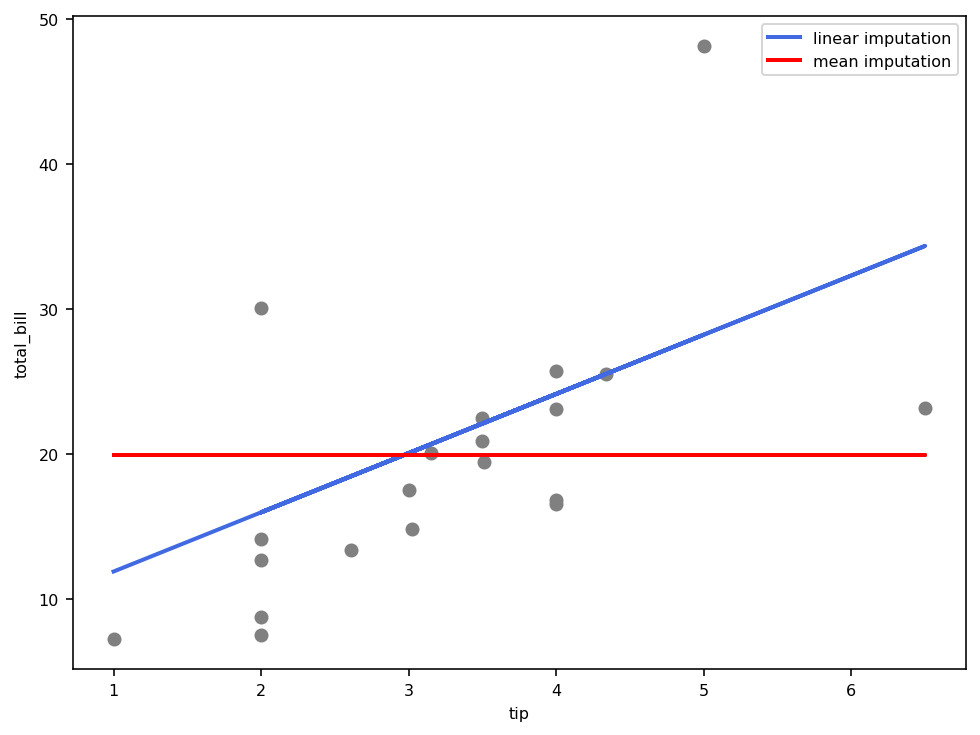

In [30]:
# Visualize the imputed total_bill values comparing to its true missing values
plt.scatter(tip_misbill, df_train_all['total_bill'][missing_bill], color='gray')
plt.plot(tip_misbill, bill_pred, color='royalblue', linewidth=2, label='linear imputation')
plt.plot(tip_misbill, mean_total_bill*np.ones(tip_misbill.shape), color='r', linewidth=2, label='mean imputation')

plt.xlabel("tip")
plt.ylabel("total_bill")
plt.legend()
plt.show()

As we can see, the imputed `total_bill` from a simple linear model from `tips` does not exactly recover the truth but capture the general trend (and it is better than a single value imputation such as mean imputation). We can, of course, use more variables in the regression model to get better imputation.



## K-nearest neighbour (KNN) imputation

Besides model-based imputation like regression imputation, neighbor-based imputation can also be used. K-nearest neighbor (KNN) imputation is an example of neighbor-based imputation. For a discrete variable, KNN imputer uses the most frequent value among the k nearest neighbors and, for a continuous variable, use the mean.

To use KNN for imputation, first, a KNN model is trained using complete data. For continuous data, commonly the Euclidean is used distance metric, whereas for discrete data, hamming distance is a frequent choice.

In the next example we use  `total_bill` and `tip` to impute `size` values.

In [31]:
from sklearn.neighbors import KNeighborsRegressor

# For the sake of simplicity, we set K=3
knn = KNeighborsRegressor(n_neighbors=3, weights = 'distance')
knn.fit(df_train_dropna.loc[:,['total_bill', 'tip']], df_train_dropna.loc[:, 'size'])

# Find the missing values in size
missing_size = df_train['size'].isnull()
# extract the tips of observations with total_bill missing
df_missing_size = pd.DataFrame(df_train[['total_bill', 'tip']][missing_size])

# used trained K-NN to predict missing sizes
imputed_size = knn.predict(df_missing_size)

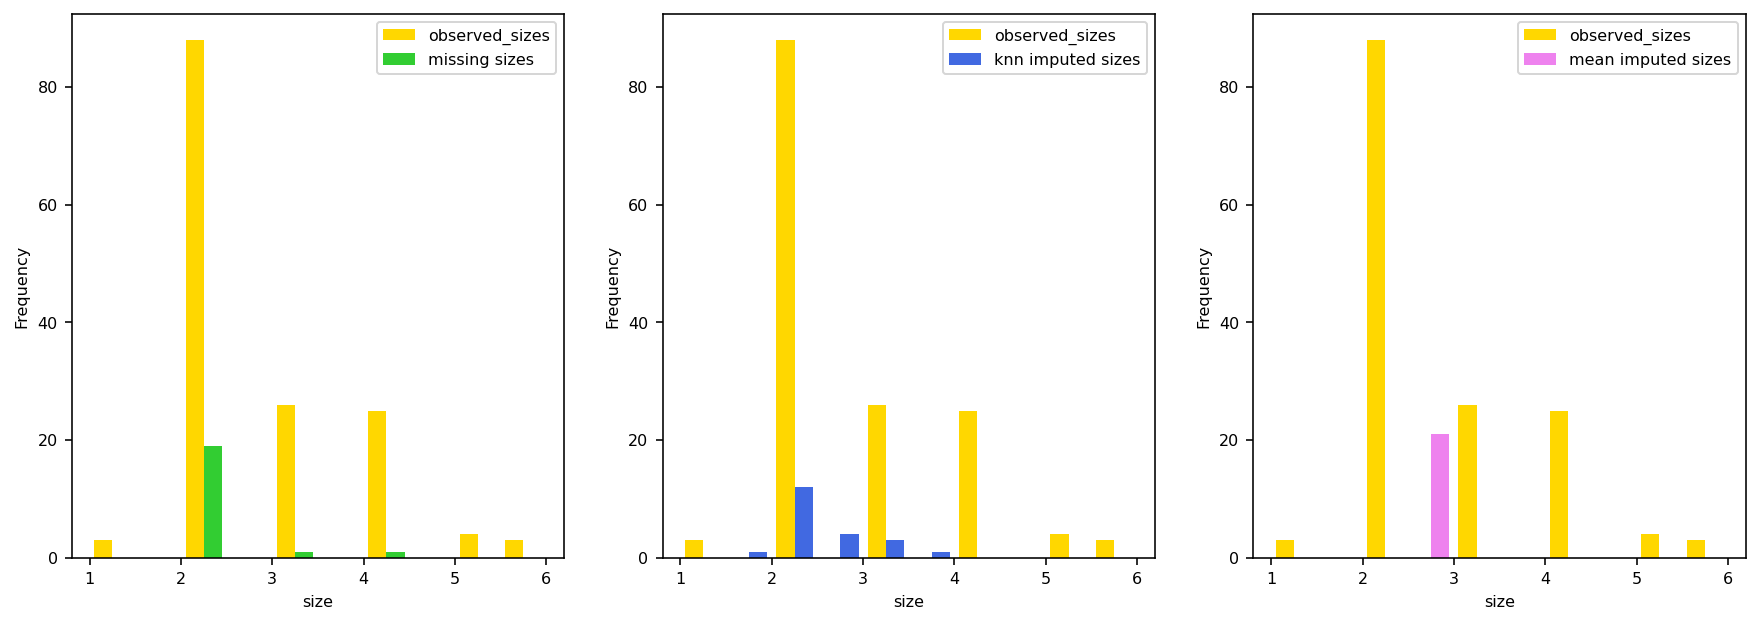

In [32]:
# Compare the imputed size distribution to its true missing values
size_obs = df_train['size'].dropna(axis=0)
size_mis = df_train_all[['size']][missing_size]
size_knn_imp = pd.DataFrame(imputed_size)
size_mean_imp = df_mean[['size']][missing_size]

legend_1 = ['observed_sizes', 'missing sizes']
legend_2 = ['observed_sizes', 'knn imputed sizes']
legend_3 = ['observed_sizes', 'mean imputed sizes']

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist([size_obs, np.squeeze(size_mis)], color=['gold', 'limegreen'])
plt.xlabel("size")
plt.ylabel("Frequency")
plt.legend(legend_1)

plt.subplot(1,3,2)
plt.hist([size_obs, np.squeeze(size_knn_imp)], color=['gold', 'royalblue'])
plt.xlabel("size")
plt.ylabel("Frequency")
plt.legend(legend_2)

plt.subplot(1,3,3)
plt.hist([size_obs,  np.squeeze(size_mean_imp)], color=['gold', 'violet'])
plt.xlabel("size")
plt.ylabel("Frequency")
plt.legend(legend_3)

plt.show()

In the plot above, we compared the missing `sizes` and imputed `sizes` using both 3NN imputer and mode imputation. As we can see, KNN imputer gives much better imputation than ad-hoc methods like mode imputation.

In general, KNN imputer is simple, flexible (can be used to any type of data), and easy to interpret. However, if the dataset is large, using a KNN imputer could be slow.

Besides, sklearn has a [`KNNImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer) class which provides imputation for filling in missing values using the K-NN approach. Besides, this implementation includes several ad-hoc functionalities:
* It includes a euclidean distance metric that supports missing values, `nan_euclidean_distances`.
* By default, each missing feature is imputed using values from `n_neighbors` nearest neighbors that have a value for the feature. 
* If a sample has more than one feature missing, then the neighbors for that sample can be different depending on the particular feature being imputed. 
*  When the number of available neighbors is less than `n_neighbors`, the mean value for that feature is used during imputation. 
* If a feature is always missing in training, it is removed during transform. 

The following cell shows how to use this class:

In [33]:
from sklearn.impute import KNNImputer
imp = KNNImputer(n_neighbors=2, weights="uniform")
imp.fit(df_train[['total_bill', 'size']])
imp_values=imp.transform(df_train[['total_bill', 'size']])
pd.DataFrame(imp_values,columns=['total_bill', 'size'])



,total_bill,size
0,26.88,4.0
1,27.18,5.0
2,11.35,2.0
3,24.71,3.5
4,13.00,2.0
...,...,...
165,13.97,2.0
166,13.97,2.0
167,22.16,4.0
168,22.12,3.0


Note that in the above code, we may want to learn the imputation model with a training data partition and later predict values (`transform`) over both train and test data; besides, we can also use the training labels to learn the model and improve our imputation.

Anyway, this can be done for us integrating the imputation with a ML pipeline...

In [34]:
from sklearn.impute import KNNImputer
param_grid = {
    'imp__n_neighbors' : range(1,10,2),
    'imp__weights':['uniform','distance'],
    'kNN__n_neighbors': range(1,10,2),
    'kNN__weights':['uniform','distance'],
}
pipe = Pipeline([('imp', KNNImputer()), ('scaler', StandardScaler()), ('kNN', KNeighborsRegressor())])
grid_knn = GridSearchCV(pipe, param_grid, cv=5)
grid_knn.fit(x_train, y_train)
R2_train = grid_knn.score(x_train, y_train)
R2_test = grid_knn.score(x_test, y_test)
print("R^2 en el conjunto de entrenamiento: {0:.2f}".format(R2_train))
print("R^2 en el conjunto de test: {0:.2f}".format(R2_test))
print(grid_knn.best_params_)

R^2 en el conjunto de entrenamiento: 0.48
R^2 en el conjunto de test: 0.42
{'imp__n_neighbors': 3, 'imp__weights': 'distance', 'kNN__n_neighbors': 9, 'kNN__weights': 'uniform'}


## Iterative Imputation

A more sophisticated approach is to use the [`IterativeImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) class of sklearn, which models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs `X`. A regressor is fit on `(X, y)` for known `y`. Then, the regressor is used to predict the missing values of `y`. This is done for each feature in an iterative fashion, and then is repeated for `max_iter` imputation rounds. Finally, the model returns the values of the final imputation round.



In [35]:
# This estimator is still experimental for now
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=5, random_state=0)
imp.fit(df_train[['total_bill', 'size']])
imp_values=imp.transform(df_train[['total_bill', 'size']])
pd.DataFrame(imp_values,columns=['total_bill', 'size'])


,total_bill,size
0,26.880000,3.103426
1,27.180000,3.123487
2,11.350000,2.064928
3,24.710000,2.958317
4,13.000000,2.175265
...,...,...
165,16.565066,2.000000
166,16.565066,2.000000
167,27.015543,4.000000
168,21.790305,3.000000


In [36]:
from sklearn.impute import IterativeImputer
from warnings import filterwarnings
filterwarnings('ignore')
param_grid = {
    'imp__estimator' : [KNeighborsRegressor(), LinearRegression()],
    'kNN__n_neighbors': range(1,10,2),
    'kNN__weights':['uniform','distance'],
}
pipe = Pipeline([('imp', IterativeImputer(max_iter=20, tol=0.1, random_state=0)), ('scaler', StandardScaler()), ('kNN', KNeighborsRegressor())])
grid_knn = GridSearchCV(pipe, param_grid, cv=5)
grid_knn.fit(x_train, y_train)
R2_train = grid_knn.score(x_train, y_train)
R2_test = grid_knn.score(x_test, y_test)
print("R^2 en el conjunto de entrenamiento: {0:.2f}".format(R2_train))
print("R^2 en el conjunto de test: {0:.2f}".format(R2_test))
print(grid_knn.best_params_)

R^2 en el conjunto de entrenamiento: 0.46
R^2 en el conjunto de test: 0.45
{'imp__estimator': LinearRegression(), 'kNN__n_neighbors': 9, 'kNN__weights': 'uniform'}


## Other imputation methods

So far, we have talked about some common methods that can be used for missing data imputation. Depending on the nature of the data or data type, some other imputation methods may be more appropriate. For example:

* For **longitudinal data**, such as patients’ weights over a period of visits, it might make sense to use last valid observation to fill the NA’s. In pandas, this can be done using the `ffill` method in `.fillna`.

    `df_l = df.fillna(method='ffill')`

* For **time-series data**, it might make sense to use interpolation of observed values before and after a timestamp for missing values. In pandas, various interpolation methods (e.g. polynomial, splines) can be implemented using `.interpolation`.

    `df_interp = df.interpolate(method = 'linear', limit_direction = 'forward', axis=0)`

The mean, median, mode imputation, regression imputation, KNN imputer are all methods that create a single replacement value for each missing entry. **Multiple Imputation (MI)**, rather than a different method, is more like a general approach/framework of doing the imputation procedure multiple times to create different plausible imputed datasets. The key motivation to use MI is that a single imputation cannot reflect sampling variability from both sample data and missing values, whereas the final analysis results (with different imputations) allow the data scientist to obtain understanding of how analytic results may differ as a consequence of the inherent uncertainty caused by the missing values. 

However, when the final user is not interested in measuring this uncertainty, we need to properly combine this information to provide a single imputation value.  In this sense, the iterative imputer is considered a MI approach with Chained Equations to combine all the imputation values.



# Outlier detection

Outliers are rare values that deviate from other observations on data; in other words, an outlier is an observation that is far from the rest of the observations or the center of mass of observations. Outlier detection estimators, thus, try to fit the regions where the training data is the most concentrated, ignoring the deviant observations.

Outliers can be caused human, instrumental or processing errors, for example, during the data acquisition, recording or processing or, measurement or experimental errors.

In machine learning is important to identify and remove outliers from data when training algorithms for predictive modeling.
Outliers can skew statistical measures and data distributions, providing a misleading representation of the underlying data and relationships. Removing outliers from training data prior to modeling can result in a better fit of the data and, in turn, more skillful predictions.

As outlier detection consists in detecting the observations that are far from the rest of the observations, most of the methods are based in probability density estimation, such us using the Gaussian Mixture Model (GMM) or One-class SVM (1-SVM). Besides, sklearn includes other three specific approaches:
* Isolation Forest
* Minimum Covariance Determinant
* Local Outlier Factor


As in previous sections, let's consider a dataset, in this case a synthetic one that we will contaminate with outliers, and then we will see method by method analyzing its capacity to detect outliers.

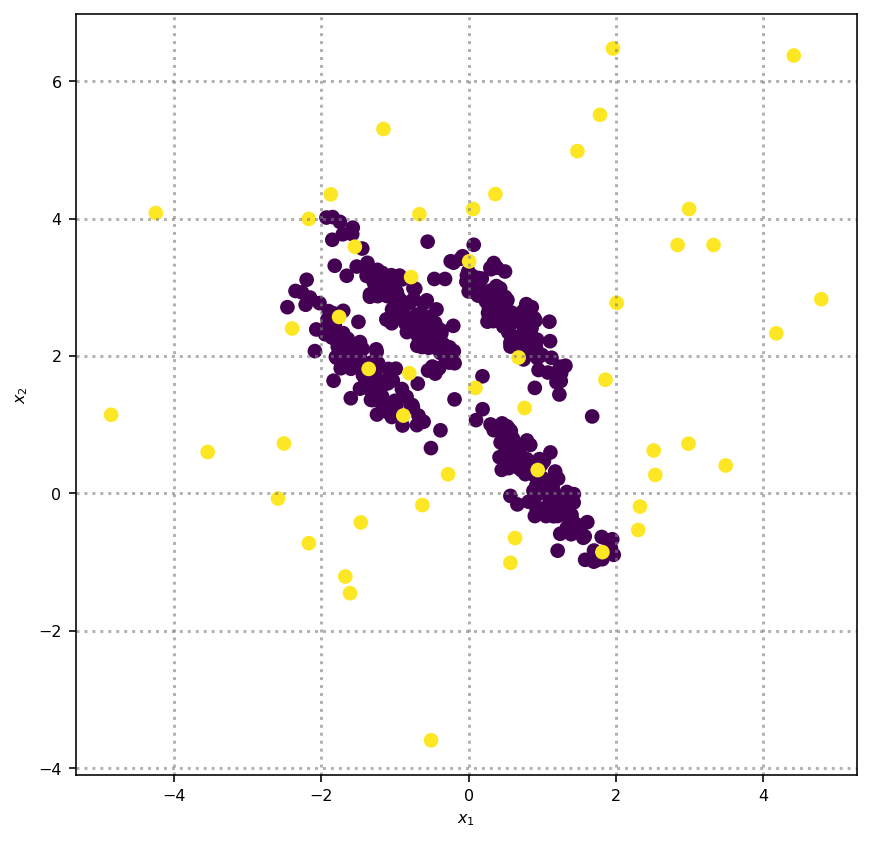

In [37]:
from sklearn.datasets import make_blobs
# Generate synthetic data
X, y_true = make_blobs(n_samples=450, centers=4,
                       cluster_std=0.60, random_state=0)

rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

# Add outliers
center_outliers = np.array([0,2]).reshape([1,-1])
X_outlier,_ = make_blobs(n_samples=50,centers=center_outliers, cluster_std=2,random_state=123)
X_out_example = np.vstack([X_stretched,X_outlier])
y_outlier = np.zeros([X_out_example.shape[0],])
y_outlier[-50:] = 1 # Vector binario que vale 1 en los outliers introducidos artificialmente

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X_out_example[:, 0], X_out_example[:, 1], c=y_outlier, s=40, cmap='viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)


When generating the outliers, we have entered data in random positions, so it is possible that some of them will fall on the inliers distribution and logically they will not be outliers and we will not be able to detect them.

## Isolation Forest

The [`IsolationForest`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest) *isolates* observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node. The most typical data will need more iterations (splittings) or longer path lengths to be isolated; so this path length, averaged over a forest of such random trees, is a measure of normality and our decision function for outlier detection. Note that random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

Perhaps the most important hyperparameter in the model is the `contamination` argument, which is used to help estimate the number of outliers in the dataset. This is a value between 0.0 and 0.5 and by default is set to 0.1.

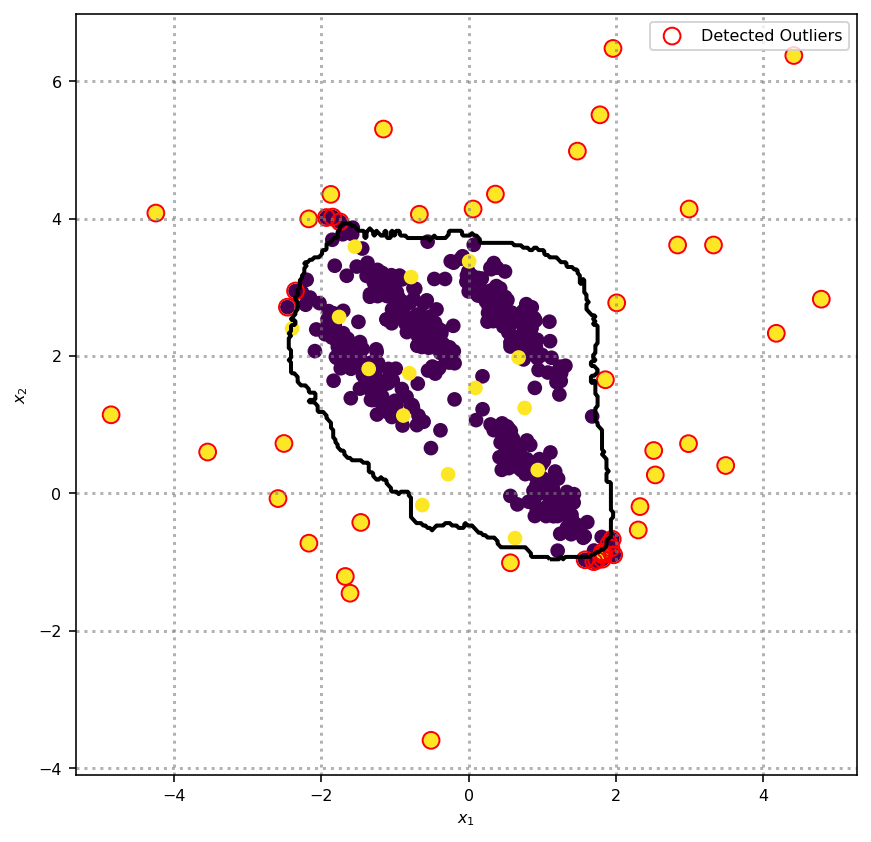

In [38]:
from sklearn.ensemble import IsolationForest
# identify outliers in the training dataset
iForest = IsolationForest(contamination=0.1)
youtliers = iForest.fit_predict(X_out_example)

idx_outliers =  np.where(youtliers == -1)[0]

fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(X_out_example[:, 0], X_out_example[:, 1], c=y_outlier, s=40, cmap='viridis')
ax.scatter(X_out_example[idx_outliers, 0], X_out_example[idx_outliers, 1], marker="o",facecolor="none",edgecolor="r",s=70, label='Detected Outliers')
plt.legend()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)

# Plot boundary
# We created a grid
intervals = 200
x = np.linspace(-3, 3, intervals)
y = np.linspace(-2, 5, intervals)
X,Y = np.meshgrid(x,y)
xys = np.vstack([X.ravel(), Y.ravel()]).T
ygrid = iForest.predict(xys)
ygrid = ygrid.reshape([intervals,intervals])

ax.contour(X, Y, ygrid, levels=[0], linewidths=2, colors='black') 


## Minimum Covariance Determinant or Elliptic Envelope

If the input variables have a Gaussian distribution, then simple statistical methods can be used to detect outliers. For example, if the dataset has two input variables and both are Gaussian, then the feature space forms a multi-dimensional Gaussian and knowledge of this distribution can be used to identify values far from the distribution.
This approach can be generalized by defining a hypersphere (ellipsoid) that covers the normal data, and data that falls outside this shape is considered an outlier. 

The [EllipticEnvelope](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope) class of sklearn implements this approach and it provides the `contamination` argument that defines the expected ratio of outliers to be observed. 

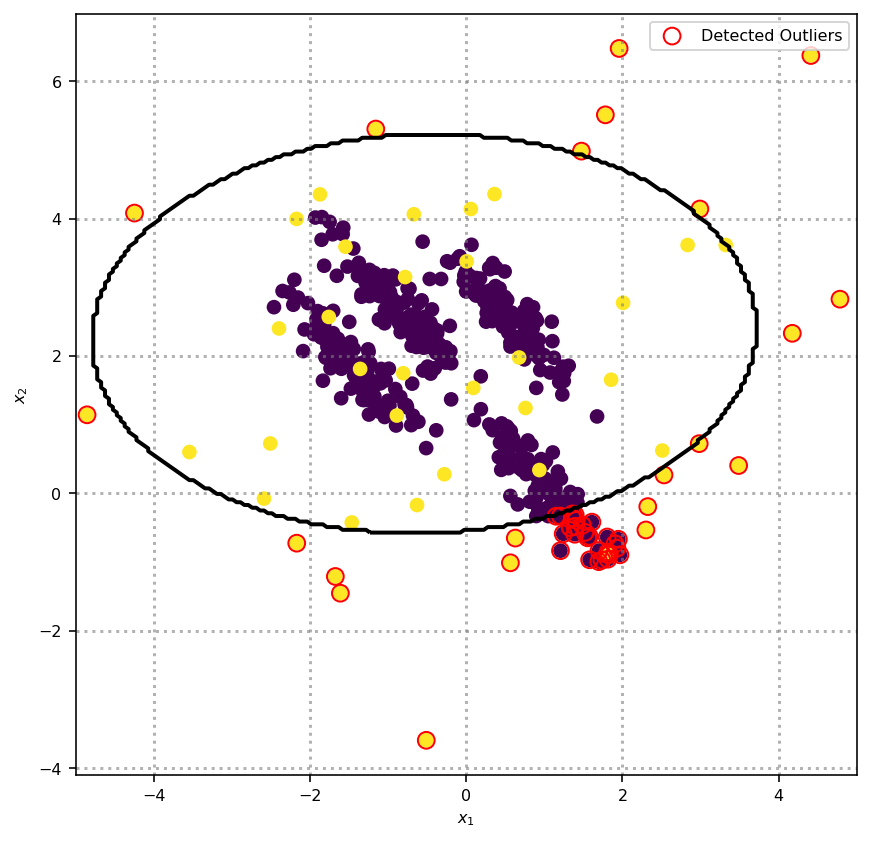

In [39]:
from sklearn.covariance import EllipticEnvelope
# identify outliers in the training dataset
ee = EllipticEnvelope(contamination=0.1)
youtliers = ee.fit_predict(X_out_example)

idx_outliers =  np.where(youtliers == -1)[0]

fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(X_out_example[:, 0], X_out_example[:, 1], c=y_outlier, s=40, cmap='viridis')
ax.scatter(X_out_example[idx_outliers, 0], X_out_example[idx_outliers, 1], marker="o",facecolor="none",edgecolor="r",s=70, label='Detected Outliers')
plt.legend()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)


# Plot boundary
# We created a grid
intervals = 200
x = np.linspace(-5, 5, intervals)
y = np.linspace(-2, 6, intervals)
X,Y = np.meshgrid(x,y)
xys = np.vstack([X.ravel(), Y.ravel()]).T
ygrid = ee.predict(xys)
ygrid = ygrid.reshape([intervals,intervals])

ax.contour(X, Y, ygrid, levels=[0], linewidths=2, colors='black') 


## Local Outlier Factor

The [local outlier factor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor), or LOF for short, measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by a KNN, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. 

This can work well for feature spaces with low dimensionality (few features), although it can become less reliable as the number of features is increased, referred to as the *curse of dimensionality*.

Here we find two parameters to adjust, the `contamination` level and the number of neighbors (set to 20 by default).

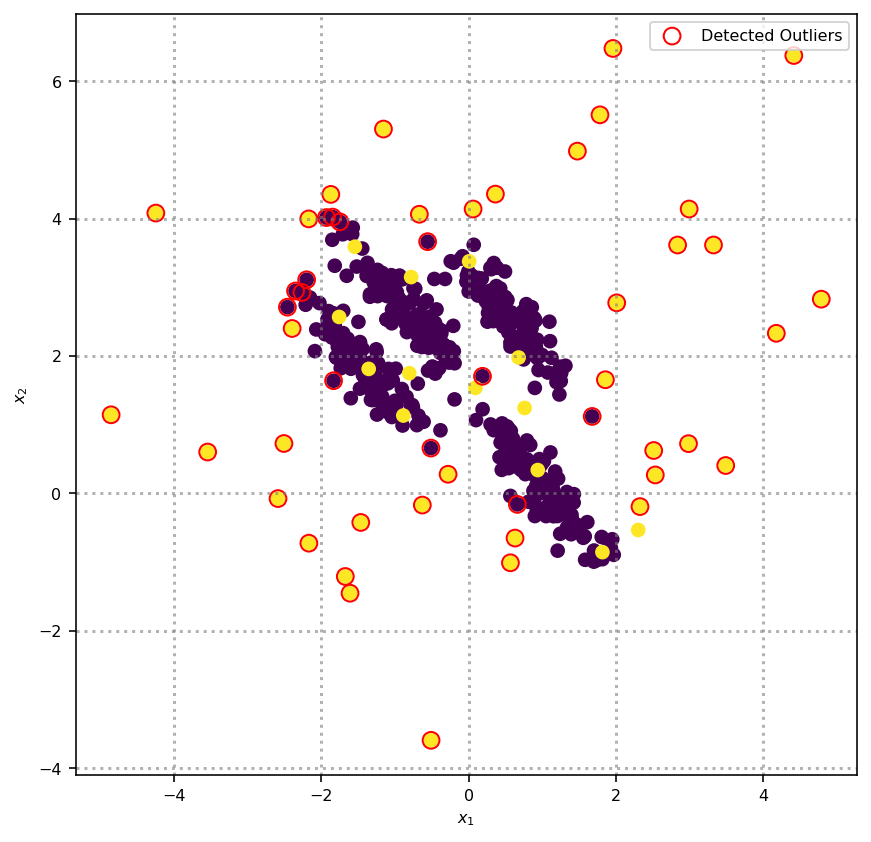

In [40]:
from sklearn.neighbors import LocalOutlierFactor

# identify outliers in the training dataset
lof = LocalOutlierFactor(contamination=0.1)
youtliers = lof.fit_predict(X_out_example)

idx_outliers =  np.where(youtliers == -1)[0]

fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(X_out_example[:, 0], X_out_example[:, 1], c=y_outlier, s=40, cmap='viridis')
ax.scatter(X_out_example[idx_outliers, 0], X_out_example[idx_outliers, 1], marker="o",facecolor="none",edgecolor="r",s=70, label='Detected Outliers')
plt.legend()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)


## One-Class SVM

The support vector machine, or SVM, algorithm developed initially for binary classification can be used for one-class classification, that is, it is able to establishing the borders of the data support. This way, the 1-SVM captures the density of the majority class and classifies examples on the extremes of the density function as outliers. 

The scikit-learn library provides an implementation of 1-SVM in the [`OneClassSVM`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM) class. This model requires the choice of a kernel and a contamination parameter to define a boundary. Normally a kernel RBF is chosen although there is no exact formula or algorithm to establish its bandwidth parameter. The contamination parameter known as the SVM boundary of a class is called `nu` and corresponds to the approximate proportion of outliers in the data set. The 'OneClassSVM' class sets the default value of `nu` to 0.1.

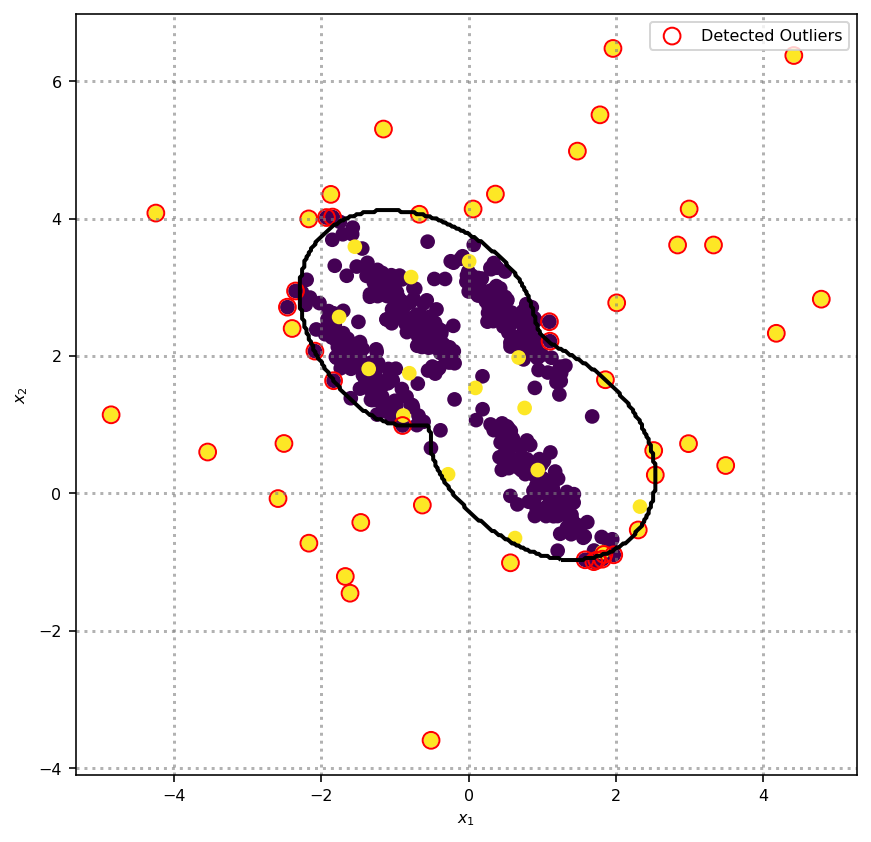

In [41]:
from sklearn.svm import OneClassSVM
from matplotlib import cm
# identify outliers in the training dataset
oneSVM = OneClassSVM(nu=0.1)
youtliers = oneSVM.fit_predict(X_out_example)
idx_outliers =  np.where(youtliers == -1)[0]

fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(X_out_example[:, 0], X_out_example[:, 1], c=y_outlier, s=40, cmap='viridis')
ax.scatter(X_out_example[idx_outliers, 0], X_out_example[idx_outliers, 1], marker="o",facecolor="none",edgecolor="r",s=70, label='Detected Outliers')
plt.legend()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)

# Plot boundary
# We created a grid
intervals = 200
x = np.linspace(-3, 3, intervals)
y = np.linspace(-1.5, 4.5, intervals)
X,Y = np.meshgrid(x,y)
xys = np.vstack([X.ravel(), Y.ravel()]).T
ygrid = oneSVM.predict(xys)
ygrid = ygrid.reshape([intervals,intervals])

ax.contour(X, Y, ygrid, levels=[0], linewidths=2, colors='black') 


## Gaussian Mixture Models (GMM)

The [mixing models](http://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch20.pdf) are a type of probabilistic data model that allows approximate the probability density of the data and, thus, use this information to detect values far from the distribution.
A GMM model will adjust a parameterized probability density function to our data as follows:

\begin{align}
p(\mathbf{x}) = \sum_{k=1}^{K} \pi_k \mathcal{N}(\mathbf{x}|\mathbf{\mu}_k,\mathbf{\Sigma}_k)
\end{align}

where

- $\pi_k$ is the probability that the data comes from the $k$-th gaussian.


- We assume that all data assigned to the $k$-th gaussian are distributed according to a Gaussian mean of $\mathbf{\mu}_k$ and a $\mathbf{\sigma}_k$ covariance matrix. 


- $(\pi_1,\ldots,\pi_K)$, $(\mathbf \mu_1,\ldots,\mathbf \mu_K)$, $(\mathbf{\Sigma}_1,\ldots,\mathbf{\Sigma}_K)$ are the **model parameters**.

These model parameters are chosen to maximize the **probability of already observed data or evidence**:


$$ \max_{(\pi_1,\ldots,\pi_K),(\mathbf{\mu}_1,\ldots,\mathbf{\mu}_K), (\mathbf{\Sigma}_1,\ldots,\mathbf{\Sigma}_K)}  ~~\sum_{n=1}^{N} \log  p(\mathbf{x}_n) $$

This problem is solved numerically by an iterative algorithm known as **EM** (Expectation-Maximization).

Although this approach is not included in sklearn as a novelty detection technique, we can use its [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) implementation for data modeling and clustering, as it is commonly used. 

Note that this approach can be considered an extension of Elliptic Envelope approach where instead of considering a single gaussian to model our data, we use a mixture of gaussian to be able to model more complex data distributions.


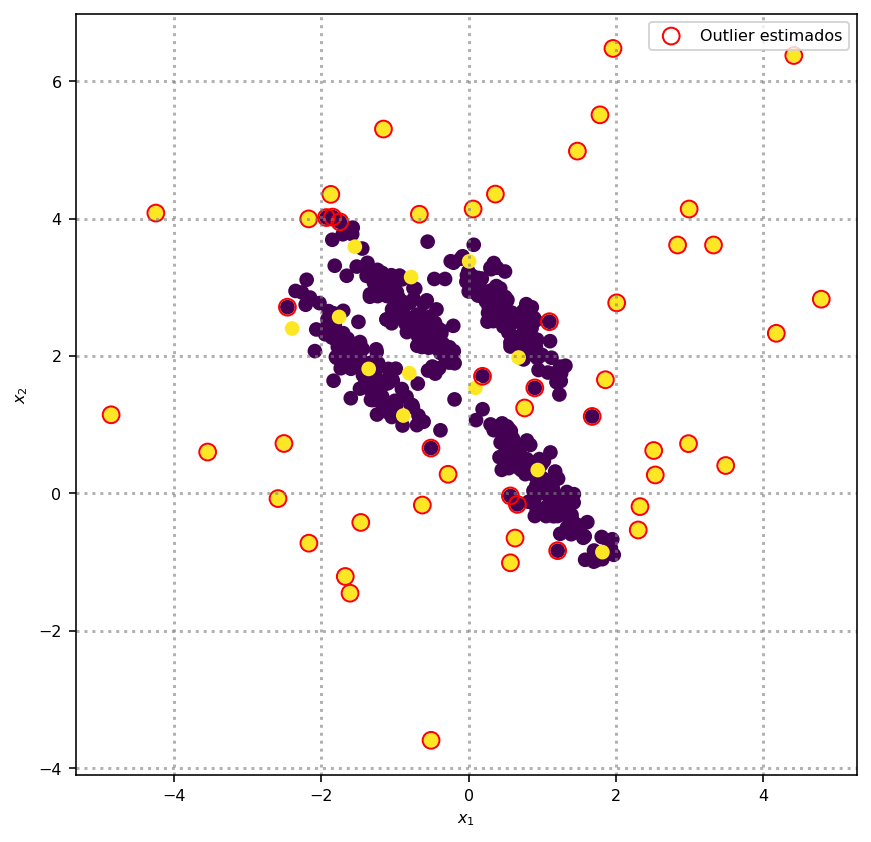

In [42]:
from sklearn.mixture import GaussianMixture
# As we know the dataset, we set K=4 (otherwise this parameters has to be selected)
gmm = GaussianMixture(n_components=4,covariance_type='full',n_init=200) 
gmm.fit(X_out_example) 
log_probs = gmm.score_samples(X_out_example)
y_outlier_pred = np.zeros([X_out_example.shape[0],])
frac = 0.1 # We set the number of contaminated data
idx_outliers = np.argsort(log_probs)[:int(np.round(X_out_example.shape[0]*frac))]

fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(X_out_example[:, 0], X_out_example[:, 1], c=y_outlier, s=40, cmap='viridis')
ax.scatter(X_out_example[idx_outliers, 0], X_out_example[idx_outliers, 1], marker="o",facecolor="none",edgecolor="r",s=70, label='Outlier estimados')
plt.legend()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)

For this model we can plot the contour curves, that is, the curves over space $(x_1,x_2)$ with equal probability $p(\mathbf{x})$. Also the learned $p(\mathbf{x})$ in a 3D figure. In this way, we can analyze the data distribution.

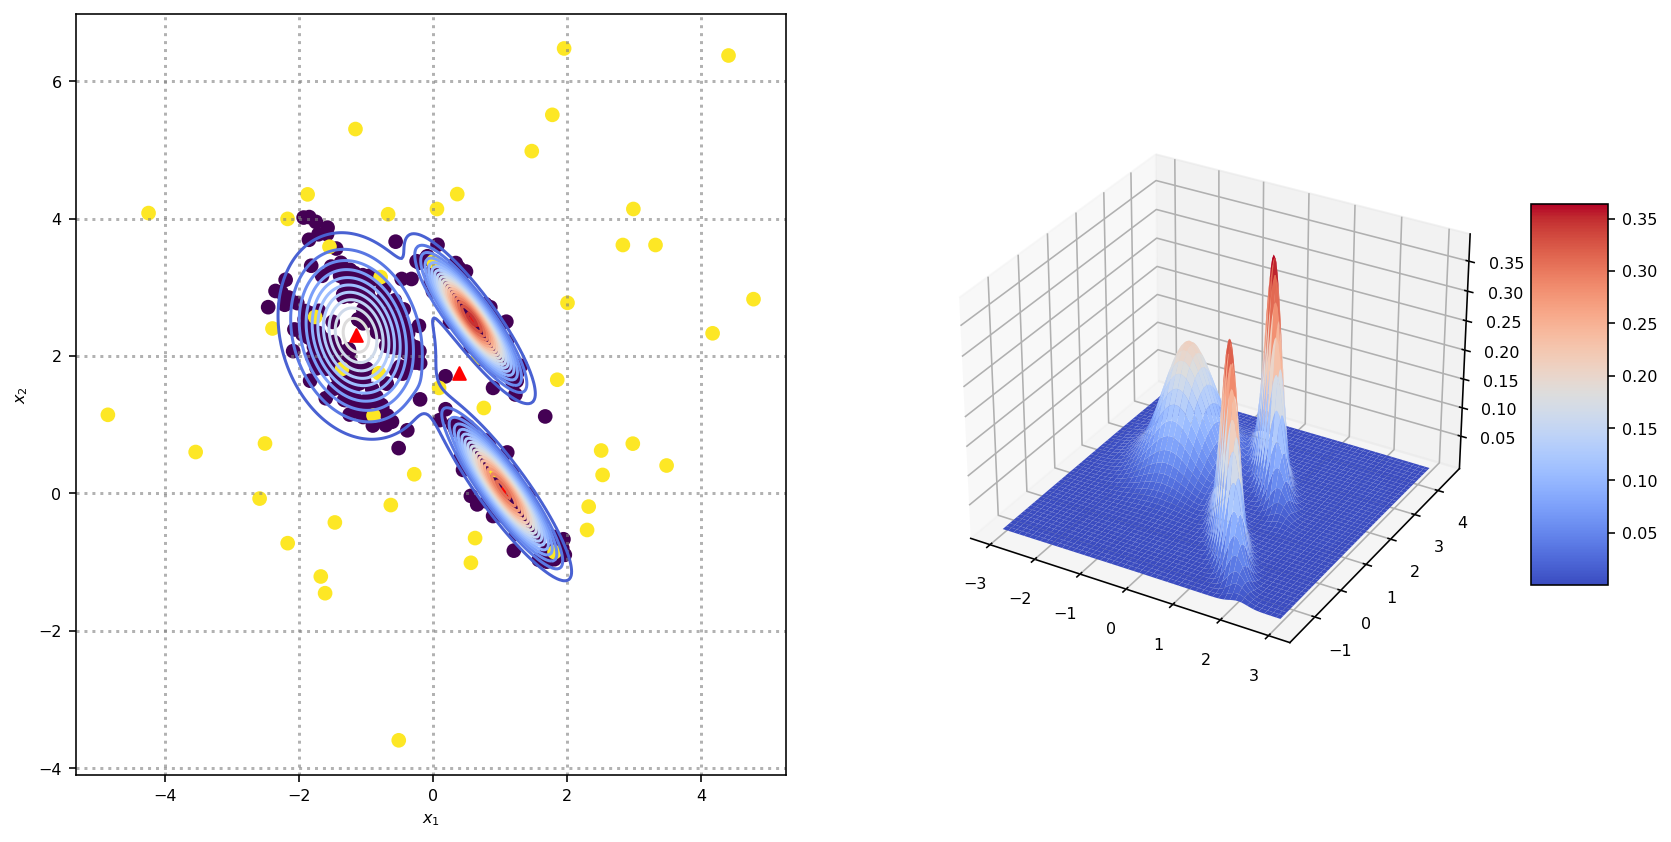

In [43]:
from scipy.stats import multivariate_normal as mvn #Multivariate normal distribution
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Lets plot the pdf contour plot
intervals = 200

# We created a grid
x = np.linspace(-3, 3, intervals)
y = np.linspace(-1.5, 4.5, intervals)

X,Y = np.meshgrid(x,y)

xys = np.vstack([X.ravel(), Y.ravel()]).T

# We evaluate p(x) for each point of the grid
K=4
Zgmm = np.zeros(len(xys))
for k in range(K):
    Zgmm += gmm.weights_[k]*mvn(gmm.means_[k,:], gmm.covariances_[k]).pdf(xys)
    
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 2, 1)

Zgmm = Zgmm.reshape([intervals,intervals])
ax.contour(X, Y, Zgmm, 20, cmap=cm.coolwarm) 
ax.scatter(X_out_example[:, 0], X_out_example[:, 1], c=y_outlier, s=40, cmap='viridis')
ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=40, marker='^', facecolor='red')

ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(X, Y, Zgmm, cmap=cm.coolwarm)
ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
